<a href="https://colab.research.google.com/github/yudy4431/Bitocin-Predicted-By-LSTM-Deep-Learning-Module/blob/main/Bitcoin_prediction_price_by_LSTM(by_hours).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import numpy as np 
import pandas as pd 
from datetime import datetime
import matplotlib.pyplot as plt

In [ ]:
# Linked to google drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **Pre-Processing Data**

***bitcoin data processing.***

In [ ]:
# Read files.
bit_path = "/content/gdrive/MyDrive/Colab_Notebooks/bitcoin/bitstampUSD_1-min_data_2012-01-01_to_2020-09-14.csv"
df = pd.read_csv(bit_path)
# Transform Unix timestamp(int) to timestamp(yyyy-mm-dd hh24:mi:ss).
df['Timestamp'] = [datetime.fromtimestamp(x) for x in df['Timestamp']]
# Delete original index of 0,1,2... and Timestep col, use new index (Timestep).
# make a DatetimeIndex !
df = df.set_index('Timestamp')

# Change the timestamp from minute demonstrated to day demonstrated 
# and get the mean of data(without NaN) in a hour.
# Object must have a datetime-like index (DatetimeIndex, PeriodIndex, or TimedeltaIndex)
df = df.resample("h").mean() 
# # If we print df_daily.info(), can see 3181 rows in data, which means 3181 days from 2011/12/31 to 2020/09/14.
# # Check if there are nulls in df_daily.
# df_daily.isnull().sum()
# # There are 3 NaN in each column.
# # Replace the NaN value by interpolate.
df['Open'] = df['Open'].interpolate()
df['Close'] = df['Close'].interpolate()
df['Weighted_Price'] = df['Weighted_Price'].interpolate()
df['Volume_(BTC)'] = df['Volume_(BTC)'].interpolate()
df['Volume_(Currency)'] = df['Volume_(Currency)'].interpolate()
df['High'] = df['High'].interpolate()
df['Low'] = df['Low'].interpolate()

df.info()
df.head()
# # There are no NaN value in data.
df.isnull().sum()	# 0 NaN.
# # Make a new dataframe with date and close price.
date_close_price = df.reset_index()[['Timestamp','Close']].rename({'Timestamp':'date','Close':'close_price'}, axis=1)
date_close_price.info()
date_close_price.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 76314 entries, 2011-12-31 07:00:00 to 2020-09-14 00:00:00
Freq: H
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               76314 non-null  float64
 1   High               76314 non-null  float64
 2   Low                76314 non-null  float64
 3   Close              76314 non-null  float64
 4   Volume_(BTC)       76314 non-null  float64
 5   Volume_(Currency)  76314 non-null  float64
 6   Weighted_Price     76314 non-null  float64
dtypes: float64(7)
memory usage: 4.7 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76314 entries, 0 to 76313
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         76314 non-null  datetime64[ns]
 1   close_price  76314 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.2 MB


,date,close_price
76309,2020-09-13 20:00:00,10304.580333
76310,2020-09-13 21:00:00,10313.530000
76311,2020-09-13 22:00:00,10309.446833
76312,2020-09-13 23:00:00,10317.951333
76313,2020-09-14 00:00:00,10332.370000


# **Training And Testing Module Set Processing.**

***Visualize data.***

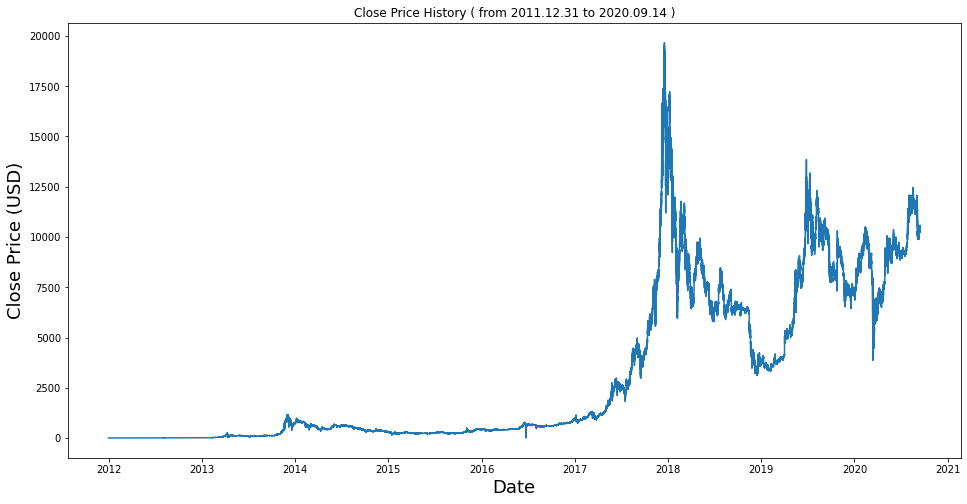

In [ ]:
# Visualize the closing price history.
plt.figure(figsize=(16, 8))
plt.title("Close Price History ( from 2011.12.31 to 2020.09.14 )")
plt.plot(date_close_price["date"], date_close_price["close_price"])
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price (USD)", fontsize=18)
plt.show()

***Split training and testing data.***

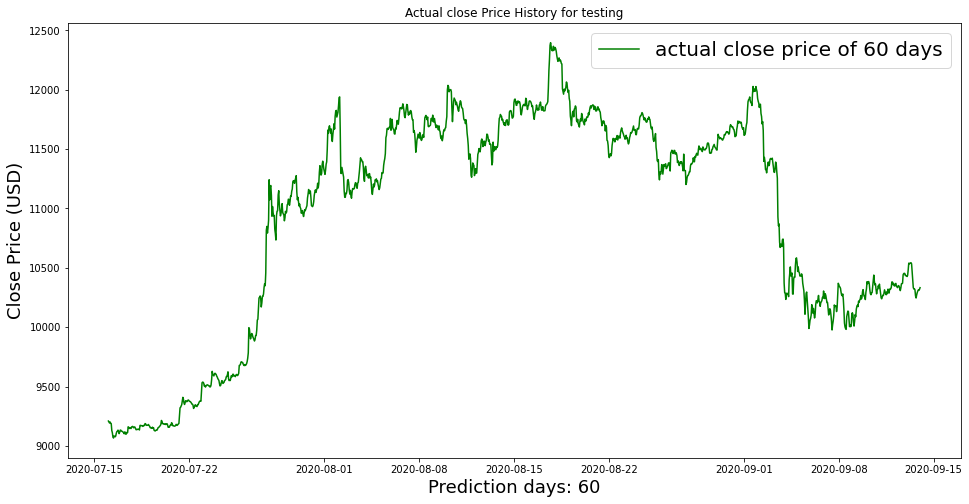

In [ ]:
prediction_days = 1440 # 1440/24hr = 60 days
# Separate data with n days to test and 3181-n days to train where n = prediction_days/24hr.
actual_show = date_close_price.iloc[len(date_close_price)-prediction_days:]
# Visualize the closing price history of test set.
plt.figure(figsize=(16, 8))
plt.title("Actual close Price History for testing")
# Testing set
plt.plot(actual_show["date"], actual_show["close_price"], color = 'green', label=f"actual close price of {prediction_days//24} days")
plt.legend(fontsize=20)
plt.xlabel(f"Prediction days: {prediction_days//24}", fontsize=18)
plt.ylabel("Close Price (USD)", fontsize=18)
plt.show()

In [ ]:
# Drop date column.
data = date_close_price.drop(["date"], axis=1)
# from 0~3181-n days
train = data.iloc[:len(data)-prediction_days]
# # actual value of prediction days
test = data.iloc[len(data)-prediction_days:]
train.head()

,close_price
0,4.39
1,4.39
2,4.39
3,4.39
4,4.39


***Training set.***

In [ ]:
from sklearn.preprocessing import MinMaxScaler


# Standard Scaler
scaler = MinMaxScaler(feature_range=(0,1))

close_train = np.array(train.values)
print(close_train.shape)
#close_train = close_train.reshape(close_train.shape[0],2)
close_train = scaler.fit_transform(close_train)
print(close_train.shape)
# Predict 1 day data using last timestep days data before.
# [row range, index to get]
timestep = 2160 # 2160/24hr = 90 days

x_train = []
y_train = []
for i in range(timestep, close_train.shape[0]):
    x_train.append(close_train[i-timestep:i,:close_train.shape[1]])
    # if i == timestep:
    #   print(close_train[i-timestep:i,:close_train.shape[1]])
    y_train.append(close_train[i,0])


x_train, y_train = np.array(x_train), np.array(y_train)
print(x_train.shape)
print(y_train.shape)
#print(x_train)
#x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],2) #reshaped for RNN


(74874, 1)
(74874, 1)
(72714, 2160, 1)
(72714,)


***Testing set.***

In [ ]:
timestep = 2160 # 2160/24hr = 90 days
close_test = data[len(data)-len(test)-timestep: ]
# print(close_test.head(51))
close_test = np.array(close_test.values)
# print(close_test)
# close_test = close_test.values.reshape(-1,2)
# Standard Scaler
close_test = scaler.transform(close_test)

# 
x_test, y_test = [], []
for i in range(timestep, close_test.shape[0]):
    x_test.append(close_test[i-timestep:i, :close_test.shape[1]])
    y_test.append(close_test[i,0])
    
x_test, y_test = np.array(x_test), np.array(y_test)
#x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 2)
print(x_test.shape, y_test.shape)


(1440, 2160, 1) (1440,)


# **Module Training And Testing.**

In [ ]:

from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout,Flatten
from keras import optimizers
from keras.callbacks import EarlyStopping
import datetime

epoch = 1000
lstm_starttime = datetime.datetime.now()

model=Sequential()
model.add(LSTM(7,input_shape=(None,1), return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(14, return_sequences=False))
model.add(Dropout(0.25))
model.add(Dense(1))

adam = optimizers.Adam(lr=5e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss="mse", optimizer=adam)
lstm_history = model.fit(x_train,y_train,epochs=epoch,batch_size=256, validation_split=0.1,
                         shuffle=True,callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode="auto", restore_best_weights=True)])


lstm_endtime = datetime.datetime.now()
lstm_runtime = lstm_endtime - lstm_starttime

print(f"LSTM cost {lstm_runtime.seconds} seconds for {len(lstm_history.epoch)} epochs.")

model.summary()

Epoch 1/1000
256/256 [==============================] - 618s 2s/step - loss: 0.0479 - val_loss: 0.1214
Epoch 2/1000
256/256 [==============================] - 620s 2s/step - loss: 0.0275 - val_loss: 0.0349
Epoch 3/1000
256/256 [==============================] - 617s 2s/step - loss: 0.0108 - val_loss: 6.1185e-04
Epoch 4/1000
256/256 [==============================] - 636s 2s/step - loss: 0.0030 - val_loss: 2.6100e-04
Epoch 5/1000
256/256 [==============================] - 639s 2s/step - loss: 0.0028 - val_loss: 2.9743e-04
Epoch 6/1000
256/256 [==============================] - 633s 2s/step - loss: 0.0026 - val_loss: 2.1852e-04
Epoch 7/1000
256/256 [==============================] - 634s 2s/step - loss: 0.0024 - val_loss: 1.8717e-04
Epoch 8/1000
256/256 [==============================] - 637s 2s/step - loss: 0.0023 - val_loss: 2.8189e-04
Epoch 9/1000
256/256 [==============================] - 636s 2s/step - loss: 0.0022 - val_loss: 1.7772e-04
Epoch 10/1000
256/256 [======================

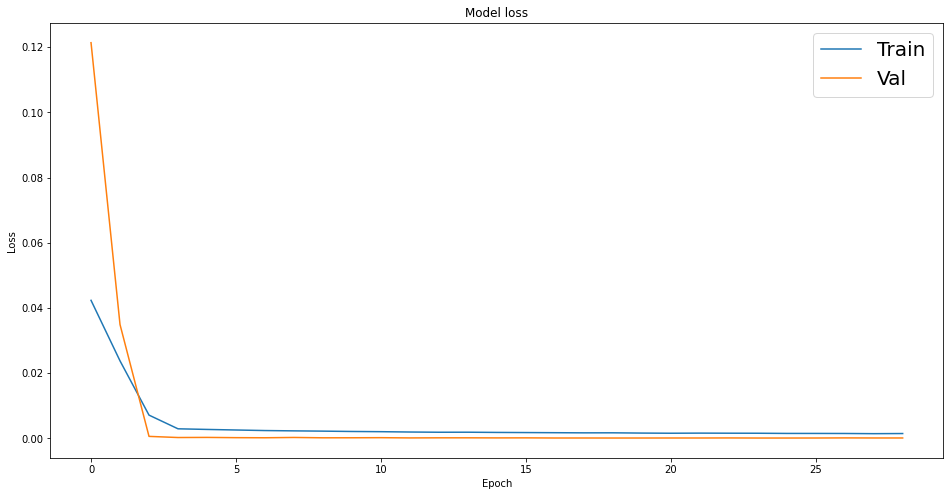

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], fontsize=20)
plt.show()

In [ ]:
model.evaluate(x_test, y_test, batch_size=16)

90/90 [==============================] - 20s 209ms/step - loss: 1.3272e-04


0.00013271991338115185

In [ ]:
LSTM_predicted_data_before_trans = model.predict(x_test)
LSTM_predicted = scaler.inverse_transform(LSTM_predicted_data_before_trans)
LSTM_predicted = np.reshape(LSTM_predicted, (LSTM_predicted.shape[0],))
print(LSTM_predicted.shape)
print(LSTM_predicted)

(1440,)
[ 9193.253  9191.106  9188.964 ... 10351.123 10342.148 10332.882]


In [ ]:
actual_days = np.array(actual_show["close_price"].values)
print(actual_days)

[ 9209.17557692  9201.33280702  9192.63851852 ... 10309.44683333
 10317.95133333 10332.37      ]


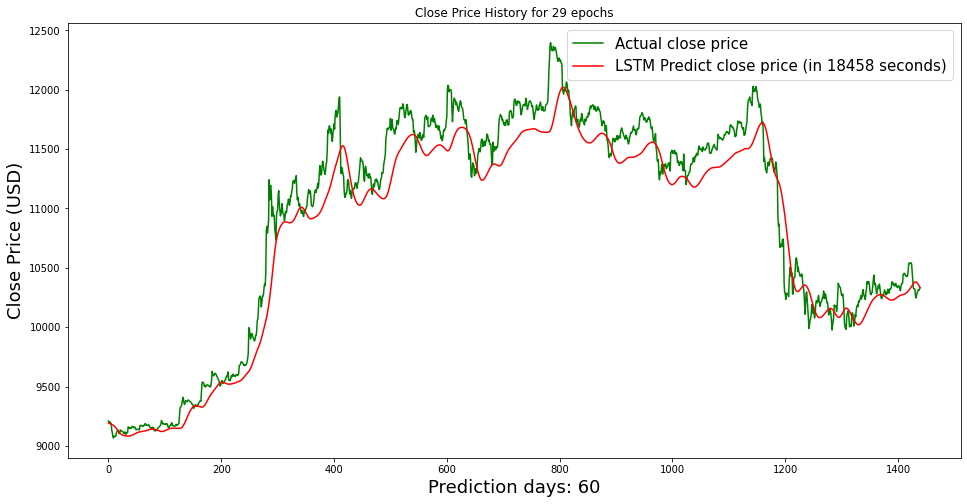

In [ ]:
# Visualize the closing price history of test set.
plt.figure(figsize=(16, 8))
plt.title(f"Close Price History for {len(lstm_history.epoch)} epochs")
# True 50 days 
plt.plot(actual_days, color = 'green', label='Actual close price')
# Predict 50 days
plt.plot(LSTM_predicted, color = 'red', label=f'LSTM Predict close price (in {lstm_runtime.seconds} seconds)')
#plt.plot(RNN_predicted_data, color = 'blue', label=f'RNN Predict close price (in {rnn_runtime.seconds} seconds)')
plt.legend(fontsize=15)
plt.xlabel(f"Prediction days: {prediction_days//24}", fontsize=18)
plt.ylabel("Close Price (USD)", fontsize=18)
plt.show()

In [ ]:
np.sum(np.sqrt((actual_days - LSTM_predicted)**2)/actual_days) / prediction_days
def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

print(rel_error(actual_days, LSTM_predicted))

0.048119454149033666


# **Save Module information.**

In [ ]:
from keras.models import load_model

# Save module construction and weights.
model.save("predicted_by_hours.h5")

In [ ]:
# Save module construction in .config.
from keras.models import model_from_json
predicted_by_hours = model.to_json() 
with open("predicted_by_hours.config", "w") as text_file:    
  text_file.write(predicted_by_hours)

In [ ]:
# Save module weights.
model.save_weights("predicted_by_hours.weight")
